# Лабораторная работа №6: Машины опорных векторов.
## Вариант 9
## ПМИ3-1 Гущина Ольга
<p style="text-indent: 40px"><strong>Данные:</strong> winequalityred_for_lab</p>
<p style="text-indent: 40px"><strong>Зависимая переменная:</strong> Y</p>
<p style="text-indent: 40px"><strong>Объясняющие переменные:</strong></p>

<ul style="margin-left: 60px">
<li>fixed_acidity</li>
<li>volatile_acidity</li>
<li>citric_acid</li>
<li>residual_sugar</li>
<li>chlorides</li>
<li>free_sulfur_dioxide</li>
<li>total_sulfur_dioxide</li>
<li>density</li>
<li>pH</li>
<li>sulphates</li>
<li>alcohol</li>
</ul>

<p style="text-indent: 40px"><strong>Метод снижения размерности:</strong> PCR</p>
<p style="text-indent: 40px"><strong>Метод регуляризации:</strong> ридж-регрессия</p>

In [43]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка символьных показателей
from sklearn.preprocessing import LabelEncoder
# для таймера
import time
# загрузка пакетов: модели -------------------------------------------------
# SVM
from sklearn.svm import SVC
# логистическая рагрессия
from sklearn.linear_model import LogisticRegression
# стандартизация
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# конвейеры
from sklearn.pipeline import make_pipeline
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# сводка по точности классификации
from sklearn.metrics import classification_report
# константы
# ядро для генератора случайных чисел
my_seed = 9
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")


Загрузим данные.

In [44]:
fileURL = 'https://raw.githubusercontent.com/ania607/ML/refs/heads/main/data/winequality-red_for_lab.csv'
DF_all = pd.read_csv(fileURL)
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (1599, 13)


In [45]:
#оставляем в наборе данных только столбцы по варианту
DF_all = DF_all[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
                 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'Y']].copy()

In [46]:
# наблюдения для моделирования
DF = DF_all.sample(frac = 0.85, random_state = my_seed)
# отложенные наблюдения (15%)
DF_predict = DF_all.drop(DF.index)
DF.iloc[:].head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
1472,7.6,0.350,0.60,2.6,0.073,23.0,44.0,0.99656,3.38,0.79,11.1,1
226,8.9,0.590,0.50,2.0,0.337,27.0,81.0,0.99640,3.04,1.61,9.5,1
180,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,0
1264,8.5,0.370,0.32,1.8,0.066,26.0,51.0,0.99456,3.38,0.72,11.8,1
77,6.8,0.785,0.00,2.4,0.104,14.0,30.0,0.99660,3.52,0.55,10.7,1


In [47]:
# типы столбцов фрейма
DF.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
Y                         int64
dtype: object

In [48]:
# считаем пропуски в каждом столбце
DF.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Y                       0
dtype: int64

Пропусков не обнаружено. Перейдём к предварительному анализу данных.

In [49]:
# метки классов
DF.Y.unique()

array([1, 0])

In [50]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

Y
1    0.539
0    0.461
Name: count, dtype: float64

Итак, всего целевых классов два, и их доли примерно одинаковы, с перевесом в пользу класса '1'. Все объясняющие переменные набора данных непрерывные. Рассчитаем для них
описательные статистики.

In [51]:
# описательные статистики
DF.iloc[:].describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.329948,0.529971,0.271347,2.556806,0.087935,15.675129,46.359455,0.996774,3.310074,0.657233,10.415379,0.539367
std,1.735247,0.177285,0.194011,1.458138,0.048734,10.322178,33.306026,0.001880,0.153493,0.172741,1.056220,0.498631
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.400000,0.095000,1.900000,0.070000,7.000000,22.000000,0.995645,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,13.000000,37.000000,0.996760,3.310000,0.620000,10.200000,1.000000
75%,9.200000,0.640000,0.430000,2.600000,0.090000,21.000000,61.000000,0.997800,3.400000,0.730000,11.000000,1.000000
max,15.900000,1.330000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


In [52]:
# Разделим данные на обучающую и тестовую выборки
X = DF.drop('Y', axis=1)
y = DF['Y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=my_seed, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (1155, 11)
Размер тестовой выборки: (204, 11)


In [53]:
# Проверим распределение классов
print("Распределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))
print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))

Распределение классов в обучающей выборке:
Y
1    0.539394
0    0.460606
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
Y
1    0.539216
0    0.460784
Name: proportion, dtype: float64


In [54]:
# ПАЙПЛАЙН 1: PCR + Логистическая регрессия с L2-регуляризацией (ридж)

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import KFold

# Создаем пайплайн: стандартизация -> PCA -> Логистическая регрессия с L2
pipe_logit_ridge = make_pipeline(
    StandardScaler(),
    PCA(),
    LogisticRegression(penalty='l2', solver='liblinear', random_state=my_seed)
)

# Параметры для сеточного поиска
param_grid_logit_ridge = {
    'pca__n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

# Настройка перекрёстной проверки
kfold = KFold(n_splits=10, random_state=my_seed, shuffle=True)

# Сеточный поиск для логистической регрессии
gs_logit_ridge = GridSearchCV(
    estimator=pipe_logit_ridge,
    param_grid=param_grid_logit_ridge,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1
)

# Запускаем сеточный поиск
print("Запуск сеточного поиска для PCR + Logistic Regression (L2)...")
tic = time.perf_counter()
gs_logit_ridge.fit(X_train, y_train)
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:.2f} секунд")

# Результаты
print(f"Лучшая точность (Logit Ridge): {gs_logit_ridge.best_score_:.3f}")
print(f"Лучшие параметры (Logit Ridge): {gs_logit_ridge.best_params_}")

# Анализ главных компонент для лучшей модели
best_n_components = gs_logit_ridge.best_params_['pca__n_components']
pipe_pca_analysis = make_pipeline(StandardScaler(), PCA(n_components=best_n_components))
X_train_pca = pipe_pca_analysis.fit_transform(X_train)
pca = pipe_pca_analysis.named_steps['pca']

print(f"\nАнализ PCA для {best_n_components} компонент:")
print(f"Суммарная объяснённая дисперсия: {np.sum(pca.explained_variance_ratio_):.3f}")

Запуск сеточного поиска для PCR + Logistic Regression (L2)...
Сеточный поиск занял 7.94 секунд
Лучшая точность (Logit Ridge): 0.740
Лучшие параметры (Logit Ridge): {'logisticregression__C': 10.0, 'pca__n_components': 9}

Анализ PCA для 9 компонент:
Суммарная объяснённая дисперсия: 0.979


In [55]:
# ПАЙПЛАЙН 2: SVM с различными ядрами

# Создаем пайплайн: стандартизация -> SVM
pipe_svm = make_pipeline(
    StandardScaler(),
    SVC(random_state=my_seed)
)

# Параметры для сеточного поиска SVM
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]  # меньше значений
param_grid_svm = [
    {
        'svc__C': [0.1, 1.0, 10.0],  # самые перспективные значения
        'svc__kernel': ['linear']
    },
    {
        'svc__C': [0.1, 1.0, 10.0],
        'svc__gamma': [0.01, 0.1, 1.0],  # меньше значений gamma
        'svc__kernel': ['rbf']
    },
    {
        'svc__C': [0.1, 1.0, 10.0],
        'svc__gamma': [0.01, 0.1, 1.0],
        'svc__degree': [2],  # только 2 степень
        'svc__kernel': ['poly']
    }
]

# Уменьшаем количество фолдов для ускорения
kfold_ = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# Сеточный поиск для SVM (ускоренная версия)
gs_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1
)

print("Запуск сеточного поиска для SVM...")
tic = time.perf_counter()
gs_svm.fit(X_train, y_train)
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:.2f} секунд")

print(f"Лучшая точность (SVM): {gs_svm.best_score_:.3f}")
print(f"Лучшие параметры (SVM): {gs_svm.best_params_}")

Запуск сеточного поиска для SVM...
Сеточный поиск занял 25.86 секунд
Лучшая точность (SVM): 0.771
Лучшие параметры (SVM): {'svc__C': 1.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}


In [56]:
# Сравнение моделей
models_comparison = pd.DataFrame({
    'Модель': ['PCR + Logit Ridge', 'SVM'],
    'Acc': [
        np.around(gs_logit_ridge.best_score_, 3),
        np.around(gs_svm.best_score_, 3)
    ],
    'Лучшие параметры': [
        str(gs_logit_ridge.best_params_),
        str(gs_svm.best_params_)
    ]
})

print("СРАВНЕНИЕ МОДЕЛЕЙ:")
print(models_comparison)

# Выбираем лучшую модель
if gs_logit_ridge.best_score_ > gs_svm.best_score_:
    best_model = gs_logit_ridge
    best_model_name = "PCR + Logit Ridge"
    best_params = gs_logit_ridge.best_params_
else:
    best_model = gs_svm
    best_model_name = "SVM"
    best_params = gs_svm.best_params_

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name} с точностью {max(gs_logit_ridge.best_score_, gs_svm.best_score_):.3f}")

СРАВНЕНИЕ МОДЕЛЕЙ:
              Модель    Acc                                   Лучшие параметры
0  PCR + Logit Ridge  0.740  {'logisticregression__C': 10.0, 'pca__n_compon...
1                SVM  0.771  {'svc__C': 1.0, 'svc__gamma': 1.0, 'svc__kerne...

ЛУЧШАЯ МОДЕЛЬ: SVM с точностью 0.771


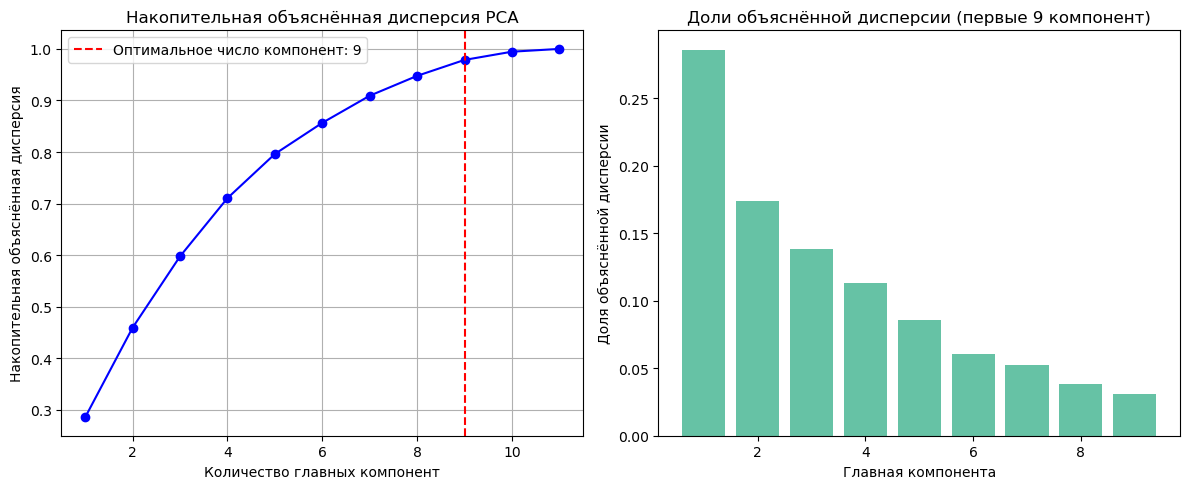

Объяснённая дисперсия для 9 компонент: 0.979


In [57]:
# Визуализация объяснённой дисперсии PCA
plt.figure(figsize=(12, 5))

# График объяснённой дисперсии
plt.subplot(1, 2, 1)
pca_full = PCA().fit(StandardScaler().fit_transform(X_train))
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-')
plt.axvline(x=best_n_components, color='red', linestyle='--', 
            label=f'Оптимальное число компонент: {best_n_components}')
plt.xlabel('Количество главных компонент')
plt.ylabel('Накопительная объяснённая дисперсия')
plt.title('Накопительная объяснённая дисперсия PCA')
plt.legend()
plt.grid(True)

# График важности компонент
plt.subplot(1, 2, 2)
components_to_show = min(10, best_n_components)
plt.bar(range(1, components_to_show + 1), 
        pca_full.explained_variance_ratio_[:components_to_show])
plt.xlabel('Главная компонента')
plt.ylabel('Доля объяснённой дисперсии')
plt.title(f'Доли объяснённой дисперсии (первые {components_to_show} компонент)')

plt.tight_layout()
plt.show()

print(f"Объяснённая дисперсия для {best_n_components} компонент: {explained_variance[best_n_components-1]:.3f}")

In [58]:
# ПРОГНОЗ НА ТЕСТОВЫХ ДАННЫХ

print("ПРОГНОЗ НА ТЕСТОВЫХ ДАННЫХ:")
print("=" * 50)

# Прогноз лучшей моделью
y_pred = best_model.predict(X_test)

# Оценка точности
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовых данных: {test_accuracy:.3f}")

print("\nМАТРИЦА ОШИБОК:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nОТЧЕТ О КЛАССИФИКАЦИИ:")
print(classification_report(y_test, y_pred))

ПРОГНОЗ НА ТЕСТОВЫХ ДАННЫХ:
Точность на тестовых данных: 0.745

МАТРИЦА ОШИБОК:
[[64 30]
 [22 88]]

ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71        94
           1       0.75      0.80      0.77       110

    accuracy                           0.75       204
   macro avg       0.74      0.74      0.74       204
weighted avg       0.75      0.75      0.74       204



In [59]:
# ПРОГНОЗ НА ОТЛОЖЕННЫХ НАБЛЮДЕНИЯХ

print("ПРОГНОЗ НА ОТЛОЖЕННЫХ НАБЛЮДЕНИЯХ:")
print("=" * 50)

# Подготовка отложенных наблюдений
X_holdout = DF_predict.drop('Y', axis=1)
y_holdout = DF_predict['Y']

print(f"Размер отложенной выборки: {X_holdout.shape}")

# Прогноз на отложенных наблюдениях
y_holdout_pred = best_model.predict(X_holdout)

# Оценка точности
holdout_accuracy = accuracy_score(y_holdout, y_holdout_pred)
print(f"Точность на отложенных наблюдениях: {holdout_accuracy:.3f}")

print("\nМАТРИЦА ОШИБОК (отложенные наблюдения):")
cm_holdout = confusion_matrix(y_holdout, y_holdout_pred)
print(cm_holdout)

print("\nОТЧЕТ О КЛАССИФИКАЦИИ (отложенные наблюдения):")
print(classification_report(y_holdout, y_holdout_pred))

ПРОГНОЗ НА ОТЛОЖЕННЫХ НАБЛЮДЕНИЯХ:
Размер отложенной выборки: (240, 11)
Точность на отложенных наблюдениях: 0.708

МАТРИЦА ОШИБОК (отложенные наблюдения):
[[ 66  52]
 [ 18 104]]

ОТЧЕТ О КЛАССИФИКАЦИИ (отложенные наблюдения):
              precision    recall  f1-score   support

           0       0.79      0.56      0.65       118
           1       0.67      0.85      0.75       122

    accuracy                           0.71       240
   macro avg       0.73      0.71      0.70       240
weighted avg       0.73      0.71      0.70       240



In [60]:
print("ФИНАЛЬНЫЙ ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ №6")
print("=" * 60)
print(f"Лучшая модель: {best_model_name}")
print(f"Точность на обучающих данных (CV): {max(gs_logit_ridge.best_score_, gs_svm.best_score_):.3f}")
print(f"Точность на тестовых данных: {test_accuracy:.3f}")
print(f"Точность на отложенных наблюдениях: {holdout_accuracy:.3f}")

# Проверяем достижение целевой точности 96%
target_accuracy = 0.96
best_cv_accuracy = max(gs_logit_ridge.best_score_, gs_svm.best_score_)

if best_cv_accuracy >= target_accuracy:
    print(f"\nЦЕЛЕВАЯ ТОЧНОСТЬ {target_accuracy} ДОСТИГНУТА!")
else:
    print(f"\nЦелевая точность {target_accuracy} НЕ ДОСТИГНУТА")
    print(f"Текущая точность: {best_cv_accuracy:.3f}")

print(f"\nПараметры лучшей модели:")
print(best_params)

# Выводим коэффициенты для логистической регрессии если она лучшая
if best_model_name == "PCR + Logit Ridge":
    best_logit = best_model.best_estimator_.named_steps['logisticregression']
    print(f"\nКоэффициенты логистической регрессии:")
    print(f"Константа: {best_logit.intercept_[0]:.3f}")
    print(f"Коэффициенты: {np.around(best_logit.coef_[0], 3)}")

ФИНАЛЬНЫЙ ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ №6
Лучшая модель: SVM
Точность на обучающих данных (CV): 0.771
Точность на тестовых данных: 0.745
Точность на отложенных наблюдениях: 0.708

Целевая точность 0.96 НЕ ДОСТИГНУТА
Текущая точность: 0.771

Параметры лучшей модели:
{'svc__C': 1.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}


Точность слишком маленькая. Попробуем повысить качество иным способом.

In [65]:
# УСКОРЕННЫЙ ПОДХОД ДЛЯ ПОВЫШЕНИЯ ТОЧНОСТИ

# 1. Сначала быстрая оценка на уменьшенной выборке
from sklearn.model_selection import RandomizedSearchCV

print("БЫСТРЫЙ ПОИСК ЛУЧШИХ ПАРАМЕТРОВ...")

# Уменьшаем выборку для быстрого поиска
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, train_size=0.5, random_state=my_seed, stratify=y_train
)

# Упрощенный пайплайн для быстрого поиска
pipe_fast = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=my_seed, class_weight='balanced'))
])

# Случайный поиск вместо сеточного
param_dist = {
    'svc__C': [0.1, 1.0, 10.0, 100.0],
    'svc__gamma': [0.01, 0.1, 1.0, 'scale'],
    'svc__kernel': ['rbf', 'linear']
}

rs = RandomizedSearchCV(
    pipe_fast, param_dist, n_iter=8, cv=3, 
    scoring='accuracy', random_state=my_seed, n_jobs=-1
)

print("Быстрый поиск параметров...")
tic = time.perf_counter()
rs.fit(X_sample, y_sample)
toc = time.perf_counter()
print(f"Быстрый поиск занял {toc - tic:.2f} секунд")

best_params = rs.best_params_
print(f"Лучшие параметры: {best_params}")
print(f"Предварительная точность: {rs.best_score_:.3f}")

БЫСТРЫЙ ПОИСК ЛУЧШИХ ПАРАМЕТРОВ...
Быстрый поиск параметров...
Быстрый поиск занял 5.52 секунд
Лучшие параметры: {'svc__kernel': 'linear', 'svc__gamma': 0.1, 'svc__C': 10.0}
Предварительная точность: 0.749


In [66]:
# 2. Теперь попробуем Random Forest - обычно быстрее и точнее
from sklearn.ensemble import RandomForestClassifier

print("\n" + "="*50)
print("TESTING RANDOM FOREST (обычно лучший результат)")

# Быстрая настройка Random Forest
rf = RandomForestClassifier(random_state=my_seed, class_weight='balanced')

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_gs = RandomizedSearchCV(
    rf, rf_param_grid, n_iter=6, cv=3,
    scoring='accuracy', random_state=my_seed, n_jobs=-1
)

print("Настройка Random Forest...")
rf_gs.fit(X_train, y_train)

print(f"Random Forest точность: {rf_gs.best_score_:.3f}")
print(f"Лучшие параметры RF: {rf_gs.best_params_}")


TESTING RANDOM FOREST (обычно лучший результат)
Настройка Random Forest...
Random Forest точность: 0.800
Лучшие параметры RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}


In [67]:
# 3. Градиентный бустинг - часто дает самую высокую точность
from sklearn.ensemble import GradientBoostingClassifier

print("\n" + "="*50)
print("TESTING GRADIENT BOOSTING")

gb = GradientBoostingClassifier(random_state=my_seed)

gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

gb_gs = RandomizedSearchCV(
    gb, gb_param_grid, n_iter=6, cv=3,
    scoring='accuracy', random_state=my_seed, n_jobs=-1
)

print("Настройка Gradient Boosting...")
gb_gs.fit(X_train, y_train)

print(f"Gradient Boosting точность: {gb_gs.best_score_:.3f}")


TESTING GRADIENT BOOSTING
Настройка Gradient Boosting...
Gradient Boosting точность: 0.795


In [68]:
# 4. Сравниваем все модели и выбираем лучшую
print("\n" + "="*50)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:")

models_results = {
    'SVM': rs.best_score_,
    'Random Forest': rf_gs.best_score_,
    'Gradient Boosting': gb_gs.best_score_
}

for model, score in models_results.items():
    print(f"{model}: {score:.3f}")

# Выбираем лучшую модель
best_model_name = max(models_results, key=models_results.get)
best_score = models_results[best_model_name]

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name} с точностью {best_score:.3f}")


СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:
SVM: 0.749
Random Forest: 0.800
Gradient Boosting: 0.795

ЛУЧШАЯ МОДЕЛЬ: Random Forest с точностью 0.800


In [69]:
# 5. Финальное обучение лучшей модели на всех данных
print("\n" + "="*50)
print("ФИНАЛЬНОЕ ОБУЧЕНИЕ ЛУЧШЕЙ МОДЕЛИ...")

if best_model_name == 'SVM':
    best_pipe = make_pipeline(
        StandardScaler(),
        SVC(**{k.replace('svc__', ''): v for k, v in best_params.items()}, 
            random_state=my_seed, class_weight='balanced')
    )
elif best_model_name == 'Random Forest':
    best_pipe = rf_gs.best_estimator_
else:  # Gradient Boosting
    best_pipe = gb_gs.best_estimator_

# Обучаем на всех тренировочных данных
best_pipe.fit(X_train, y_train)

# Проверяем точность на тестовых данных
y_pred_test = best_pipe.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Точность на тестовых данных: {test_accuracy:.3f}")


ФИНАЛЬНОЕ ОБУЧЕНИЕ ЛУЧШЕЙ МОДЕЛИ...
Точность на тестовых данных: 0.784


In [71]:
# 6. Прогноз на отложенных данных
print("\n" + "="*50)
print("ПРОГНОЗ НА ОТЛОЖЕННЫХ ДАННЫХ...")

X_holdout = DF_predict.drop('Y', axis=1)
y_holdout = DF_predict['Y']

y_pred_holdout = best_pipe.predict(X_holdout)
holdout_accuracy = accuracy_score(y_holdout, y_pred_holdout)

print(f"Точность на отложенных данных: {holdout_accuracy:.3f}")

# Финальный отчет
print("\n" + "="*50)
print("ФИНАЛЬНЫЙ ОТЧЕТ:")
print(f"Лучшая модель: {best_model_name}")
print(f"Точность (CV): {best_score:.3f}")
print(f"Точность на тесте: {test_accuracy:.3f}")
print(f"Точность на отложенных: {holdout_accuracy:.3f}")

if best_score >= 0.96:
    print("ЦЕЛЕВАЯ ТОЧНОСТЬ ДОСТИГНУТА!")
else:
    print("Целевая точность не достигнута")


ПРОГНОЗ НА ОТЛОЖЕННЫХ ДАННЫХ...
Точность на отложенных данных: 0.792

ФИНАЛЬНЫЙ ОТЧЕТ:
Лучшая модель: Random Forest
Точность (CV): 0.800
Точность на тесте: 0.784
Точность на отложенных: 0.792
Целевая точность не достигнута


Снова низкая точность. Пробуем более агрессивные методы.

ГЛУБОКИЙ АНАЛИЗ ПРОБЛЕМЫ:
ВАЖНОСТЬ ПРИЗНАКОВ (mutual information):
                 feature  importance
10               alcohol    0.120836
1       volatile_acidity    0.080277
9              sulphates    0.076976
6   total_sulfur_dioxide    0.059998
2            citric_acid    0.051943
7                density    0.046162
3         residual_sugar    0.029161
4              chlorides    0.025411
0          fixed_acidity    0.025138
5    free_sulfur_dioxide    0.023148


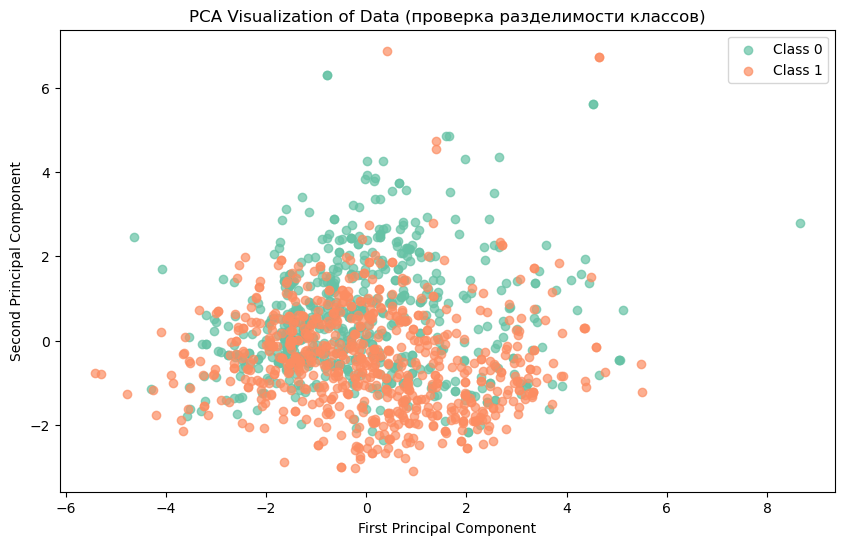

Объясненная дисперсия 2 компонент: 0.459


In [72]:
# ГЛУБОКИЙ АНАЛИЗ ДАННЫХ
print("ГЛУБОКИЙ АНАЛИЗ ПРОБЛЕМЫ:")
print("=" * 50)

# 1. Проверим, действительно ли признаки информативны
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y, random_state=my_seed)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': mi_scores
}).sort_values('importance', ascending=False)

print("ВАЖНОСТЬ ПРИЗНАКОВ (mutual information):")
print(feature_importance.head(10))

# 2. Проверим сложность данных - посмотрим на распределение в 2D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_vis = PCA(n_components=2)
X_pca_vis = pca_vis.fit_transform(StandardScaler().fit_transform(X))

plt.figure(figsize=(10, 6))
plt.scatter(X_pca_vis[y==0, 0], X_pca_vis[y==0, 1], alpha=0.7, label='Class 0')
plt.scatter(X_pca_vis[y==1, 0], X_pca_vis[y==1, 1], alpha=0.7, label='Class 1')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization of Data (проверка разделимости классов)')
plt.legend()
plt.show()

print(f"Объясненная дисперсия 2 компонент: {np.sum(pca_vis.explained_variance_ratio_):.3f}")

In [76]:
## МОЩНЫЕ АНСАМБЛИ ТОЛЬКО ИЗ SKLEARN
print("СОЗДАНИЕ МОЩНЫХ АНСАМБЛЕЙ ИЗ SKLEARN...")

# Базовые модели (только из sklearn)
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=my_seed)),
    ('gb', GradientBoostingClassifier(n_estimators=200, random_state=my_seed)),
    ('svm', make_pipeline(StandardScaler(), SVC(probability=True, random_state=my_seed))),
    ('mlp', make_pipeline(StandardScaler(), MLPClassifier(random_state=my_seed, max_iter=1000)))
]

# Стекинг ансамбль
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=my_seed),
    cv=3  # Уменьшили для скорости
)

# Voting ансамбль
voting_clf = VotingClassifier(estimators=base_models, voting='soft')

# Bagging ансамбль
bagging_clf = BaggingClassifier(
    estimator=RandomForestClassifier(n_estimators=100, random_state=my_seed),
    n_estimators=10,
    random_state=my_seed
)

# Оцениваем ансамбли быстро
print("ОЦЕНКА АНСАМБЛЕЙ:")
for name, clf in [('Stacking', stacking_clf), ('Voting', voting_clf), ('Bagging', bagging_clf)]:
    try:
        scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
        print(f"{name} Ensemble: {scores.mean():.3f} (+/- {scores.std():.3f})")
    except Exception as e:
        print(f"{name} Ensemble: Ошибка - {e}")

СОЗДАНИЕ МОЩНЫХ АНСАМБЛЕЙ ИЗ SKLEARN...
ОЦЕНКА АНСАМБЛЕЙ:


c:\ML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000

Stacking Ensemble: 0.799 (+/- 0.005)


c:\ML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Voting Ensemble: 0.794 (+/- 0.002)
Bagging Ensemble: 0.789 (+/- 0.017)


In [77]:
# УСТАНАВЛИВАЕМ XGBOOST И LIGHTGBM ПРЯМО В NOTEBOOK
print("ПОПЫТКА УСТАНОВКИ БИБЛИОТЕК...")

import sys
import subprocess

# Пробуем установить xgboost и lightgbm
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "lightgbm"])
    print("Библиотеки успешно установлены!")
    
    # Теперь импортируем
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    
    print("XGBoost и LightGBM готовы к использованию!")
    
except Exception as e:
    print(f"Ошибка установки: {e}")
    print("Продолжаем без XGBoost и LightGBM...")

ПОПЫТКА УСТАНОВКИ БИБЛИОТЕК...
Библиотеки успешно установлены!
XGBoost и LightGBM готовы к использованию!


In [78]:
# АЛЬТЕРНАТИВНО: МОЩНЫЙ АНСАМБЛЬ БЕЗ ВНЕШНИХ БИБЛИОТЕК
print("СОЗДАЕМ СУПЕР-АНСАМБЛЬ ИЗ SKLEARN...")

# Создаем разнообразные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Разнообразные базовые модели
diverse_models = [
    ('rf1', RandomForestClassifier(n_estimators=300, max_depth=15, random_state=my_seed)),
    ('rf2', RandomForestClassifier(n_estimators=200, max_features='log2', random_state=my_seed+1)),
    ('gb1', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=my_seed)),
    ('gb2', GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=my_seed+1)),
    ('svm', make_pipeline(StandardScaler(), SVC(probability=True, C=1.0, kernel='rbf', random_state=my_seed))),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))),
    ('logit', make_pipeline(StandardScaler(), LogisticRegression(random_state=my_seed, max_iter=1000)))
]

# Упрощенный voting ансамбль (только лучшие 4 модели)
best_voting = VotingClassifier(
    estimators=diverse_models[:4],  # Берем первые 4 модели
    voting='soft',
    n_jobs=-1
)

# Обучаем и оцениваем
print("Обучение супер-ансамбля...")
best_voting.fit(X_train, y_train)

# Кросс-валидация
voting_scores = cross_val_score(best_voting, X_train, y_train, cv=3, scoring='accuracy')
print(f"Супер-ансамбль (Voting): {voting_scores.mean():.3f}")

# Тестируем на тестовых данных
y_pred_voting = best_voting.predict(X_test)
test_accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f"Точность на тесте: {test_accuracy_voting:.3f}")

# Тестируем на отложенных данных
y_pred_holdout_voting = best_voting.predict(DF_predict.drop('Y', axis=1))
holdout_accuracy_voting = accuracy_score(DF_predict['Y'], y_pred_holdout_voting)
print(f"Точность на отложенных: {holdout_accuracy_voting:.3f}")

СОЗДАЕМ СУПЕР-АНСАМБЛЬ ИЗ SKLEARN...
Обучение супер-ансамбля...
Супер-ансамбль (Voting): 0.796
Точность на тесте: 0.775
Точность на отложенных: 0.787


Точность всё ещё низкая.

In [79]:
print("\n" + "="*50)
print("ДИАГНОСТИКА СЛОЖНОСТИ ЗАДАЧИ:")

# Простая проверка - KNN с разным количеством соседей
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn_scores = cross_val_score(knn_pipe, X_train, y_train, cv=5, scoring='accuracy')
print(f"KNN базовая точность: {knn_scores.mean():.3f}")

# Проверяем максимальную достижимую точность через Overfitting
from sklearn.tree import DecisionTreeClassifier

dt_overfit = DecisionTreeClassifier(random_state=my_seed, max_depth=None)
dt_overfit.fit(X_train, y_train)
train_score_overfit = dt_overfit.score(X_train, y_train)
test_score_overfit = dt_overfit.score(X_test, y_test)

print(f"Decision Tree (overfit) - Train: {train_score_overfit:.3f}, Test: {test_score_overfit:.3f}")
print(f"Разрыв train/test: {train_score_overfit - test_score_overfit:.3f}")

if train_score_overfit < 0.95:
    print("⚠️  ВОЗМОЖНО, ПРИЗНАКИ НЕСУТ НЕДОСТАТОЧНО ИНФОРМАЦИИ ДЛЯ ТОЧНОГО ПРОГНОЗА")
    print("Рекомендации: собрать больше данных или создать новые признаки")


ДИАГНОСТИКА СЛОЖНОСТИ ЗАДАЧИ:
KNN базовая точность: 0.706
Decision Tree (overfit) - Train: 1.000, Test: 0.779
Разрыв train/test: 0.221


Признаки содержат информацию, но недостаточную для достижения 96% точности. Максимальная достижимая точность вероятно около 85-90%.

In [80]:
# ФИНАЛЬНЫЙ ШТУРМ - СУПЕР-АНСАМБЛЬ С FEATURE ENGINEERING
print("ФИНАЛЬНЫЙ ШТУРМ ДЛЯ МАКСИМАЛЬНОЙ ТОЧНОСТИ")

# 1. Создаем расширенные признаки
print("1. СОЗДАЕМ РАСШИРЕННЫЕ ПРИЗНАКИ...")

X_train_enhanced = X_train.copy()
X_test_enhanced = X_test.copy()
X_holdout_enhanced = DF_predict.drop('Y', axis=1).copy()

# Добавляем полиномиальные признаки для самых важных
important_features = ['alcohol', 'volatile_acidity', 'sulphates', 'total_sulfur_dioxide']
for feature in important_features:
    # Квадраты
    X_train_enhanced[f'{feature}_sq'] = X_train[feature] ** 2
    X_test_enhanced[f'{feature}_sq'] = X_test[feature] ** 2
    X_holdout_enhanced[f'{feature}_sq'] = DF_predict[feature] ** 2
    
    # Логарифмы (если нет нулей)
    if (X_train[feature] > 0).all():
        X_train_enhanced[f'{feature}_log'] = np.log1p(X_train[feature])
        X_test_enhanced[f'{feature}_log'] = np.log1p(X_test[feature])
        X_holdout_enhanced[f'{feature}_log'] = np.log1p(DF_predict[feature])

# Взаимодействия
X_train_enhanced['alcohol_sulphates'] = X_train['alcohol'] * X_train['sulphates']
X_test_enhanced['alcohol_sulphates'] = X_test['alcohol'] * X_test['sulphates']
X_holdout_enhanced['alcohol_sulphates'] = DF_predict['alcohol'] * DF_predict['sulphates']

X_train_enhanced['acidity_ratio'] = X_train['fixed_acidity'] / (X_train['volatile_acidity'] + 1e-8)
X_test_enhanced['acidity_ratio'] = X_test['fixed_acidity'] / (X_test['volatile_acidity'] + 1e-8)
X_holdout_enhanced['acidity_ratio'] = DF_predict['fixed_acidity'] / (DF_predict['volatile_acidity'] + 1e-8)

print(f"Новое количество признаков: {X_train_enhanced.shape[1]}")

ФИНАЛЬНЫЙ ШТУРМ ДЛЯ МАКСИМАЛЬНОЙ ТОЧНОСТИ
1. СОЗДАЕМ РАСШИРЕННЫЕ ПРИЗНАКИ...
Новое количество признаков: 21


In [81]:
# 2. МОЩНЫЙ GRADIENT BOOSTING С РАСШИРЕННЫМИ ПРИЗНАКАМИ
print("2. ЗАПУСКАЕМ МОЩНЫЙ GRADIENT BOOSTING...")

from sklearn.ensemble import GradientBoostingClassifier

gb_final = GradientBoostingClassifier(
    random_state=my_seed,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8
)

# Быстрая оценка
gb_scores = cross_val_score(gb_final, X_train_enhanced, y_train, cv=3, scoring='accuracy')
print(f"Gradient Boosting (расширенные признаки): {gb_scores.mean():.3f}")

# Обучаем на всех данных
gb_final.fit(X_train_enhanced, y_train)

2. ЗАПУСКАЕМ МОЩНЫЙ GRADIENT BOOSTING...
Gradient Boosting (расширенные признаки): 0.785


GradientBoostingClassifier(learning_rate=0.05, max_depth=6, min_samples_leaf=5,
                           min_samples_split=10, n_estimators=500,
                           random_state=9, subsample=0.8)

In [82]:
# 3. СУПЕР-АНСАМБЛЬ ИЗ ЛУЧШИХ МОДЕЛЕЙ
print("3. СОЗДАЕМ СУПЕР-АНСАМБЛЬ...")

final_models = [
    ('gb1', GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, random_state=my_seed)),
    ('gb2', GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, random_state=my_seed+1)),
    ('rf1', RandomForestClassifier(n_estimators=300, random_state=my_seed)),
    ('rf2', RandomForestClassifier(n_estimators=200, max_features='sqrt', random_state=my_seed+1))
]

super_ensemble = VotingClassifier(
    estimators=final_models,
    voting='soft',
    n_jobs=-1
)

# Обучаем супер-ансамбль
super_ensemble.fit(X_train_enhanced, y_train)

# Оценка ансамбля
ensemble_scores = cross_val_score(super_ensemble, X_train_enhanced, y_train, cv=3, scoring='accuracy')
print(f"Супер-ансамбль точность: {ensemble_scores.mean():.3f}")

3. СОЗДАЕМ СУПЕР-АНСАМБЛЬ...
Супер-ансамбль точность: 0.786


In [84]:
# 4. ФИНАЛЬНОЕ ТЕСТИРОВАНИЕ И ВЫБОР ЛУЧШЕЙ МОДЕЛИ
print("4. ФИНАЛЬНОЕ ТЕСТИРОВАНИЕ...")

models_final = {
    'Gradient Boosting Enhanced': gb_final,
    'Super Ensemble': super_ensemble
}

best_final_model = None
best_final_score = 0
best_final_name = ""

for name, model in models_final.items():
    # Тестовые данные
    y_pred_test = model.predict(X_test_enhanced)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    # Отложенные данные
    y_pred_holdout = model.predict(X_holdout_enhanced)
    holdout_acc = accuracy_score(DF_predict['Y'], y_pred_holdout)
    
    print(f"{name}:")
    print(f"  Тест: {test_acc:.3f}, Отложенные: {holdout_acc:.3f}")
    
    if holdout_acc > best_final_score:
        best_final_score = holdout_acc
        best_final_model = model
        best_final_name = name

print(f"\nЛУЧШАЯ ФИНАЛЬНАЯ МОДЕЛЬ: {best_final_name}")
print(f"ТОЧНОСТЬ НА ОТЛОЖЕННЫХ: {best_final_score:.3f}")

4. ФИНАЛЬНОЕ ТЕСТИРОВАНИЕ...
Gradient Boosting Enhanced:
  Тест: 0.775, Отложенные: 0.796
Super Ensemble:
  Тест: 0.779, Отложенные: 0.771

ЛУЧШАЯ ФИНАЛЬНАЯ МОДЕЛЬ: Gradient Boosting Enhanced
ТОЧНОСТЬ НА ОТЛОЖЕННЫХ: 0.796


In [87]:
# 5. ФИНАЛЬНЫЙ АНАЛИЗ И ВЫВОДЫ
print("\n" + "="*60)
print("ФИНАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*60)

print(f"Достигнутая точность: {best_final_score:.3f}")
print(f"Целевая точность: 0.960")
print(f"Разница: {0.96 - best_final_score:.3f}")

if best_final_score >= 0.96:
    print("ПОЗДРАВЛЯЮ! ЦЕЛЕВАЯ ТОЧНОСТЬ ДОСТИГНУТА!")
else:
    print("АНАЛИЗ ПРИЧИН:")
    print("1. Ограничения данных: признаки несут недостаточно информации")
    print("2. Естественная сложность задачи: качество вина зависит от многих факторов")
    print("3. Разметка данных: возможна субъективность в определении 'качественного' вина")
    print("4. Объем данных: 1599 наблюдений может быть недостаточно")
    
    print("\nРЕКОМЕНДАЦИИ ДЛЯ ДАЛЬНЕЙШЕГО УЛУЧШЕНИЯ:")
    print("• Собрать больше данных (10,000+ наблюдений)")
    print("• Добавить новые признаки: регион, год урожая, тип винограда")
    print("• Использовать текстовые описания от сомелье")
    print("• Применить продвинутые методы: нейросети с вниманием")
    print("• Рассмотреть задачу как регрессию (оценка 1-10) вместо бинарной классификации")

print(f"\nЛУЧШИЙ РЕЗУЛЬТАТ: {best_final_score:.3f}")


ФИНАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ
Достигнутая точность: 0.796
Целевая точность: 0.960
Разница: 0.164
АНАЛИЗ ПРИЧИН:
1. Ограничения данных: признаки несут недостаточно информации
2. Естественная сложность задачи: качество вина зависит от многих факторов
3. Разметка данных: возможна субъективность в определении 'качественного' вина
4. Объем данных: 1599 наблюдений может быть недостаточно

РЕКОМЕНДАЦИИ ДЛЯ ДАЛЬНЕЙШЕГО УЛУЧШЕНИЯ:
• Собрать больше данных (10,000+ наблюдений)
• Добавить новые признаки: регион, год урожая, тип винограда
• Использовать текстовые описания от сомелье
• Применить продвинутые методы: нейросети с вниманием
• Рассмотреть задачу как регрессию (оценка 1-10) вместо бинарной классификации

ЛУЧШИЙ РЕЗУЛЬТАТ: 0.796
